# 装载数据

In [3]:
import pickle
node_dict={}
node_dict_amap={}
way_list=[]
road_zip={}
with open('../data/map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('../data/map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('../data/map_ways.pkl','rb') as f:
    way_list=pickle.load(f)
with open('../data/road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)   

# 清理数据
将没有在高德地图中出现的数据去除

In [4]:
# road_name中包含了高德地图包含的所有道路名称
road_name=list(set([road[0] for road in road_zip.keys()]))
# print(road_name)
del_way=[]
for way in way_list:
    if way[0] not in road_name:
        del_way.append(way)
for w in del_way:
    way_list.remove(w)

查询上海市行政区边界polyline

In [25]:
import requests
import json
import numpy as np
from fake_useragent import UserAgent
server_host='https://restapi.amap.com/v3/config/district'
parameters={
    'key':'111d1e3797ffa20c7d44a42ab0bed3fd',
    'keywords':'上海市',
    'subdistrict':0,
    'extensions':'all'
}
response=requests.get(url=server_host,
                     headers={'User-Agent':UserAgent(path='fakeuseragent.json').random},
                     params=parameters)
response.encoding=response.apparent_encoding
res=json.loads(response.text)
poly_lines=res['districts'][0]['polyline'].split('|')
poly_lines=[line.split(';') for line in poly_lines]
for i in range(len(poly_lines)):
    poly_lines[i]=np.array([point.split(',') for point in poly_lines[i]],dtype=float).T
sh_poly_lines=poly_lines

绘制道路地理图

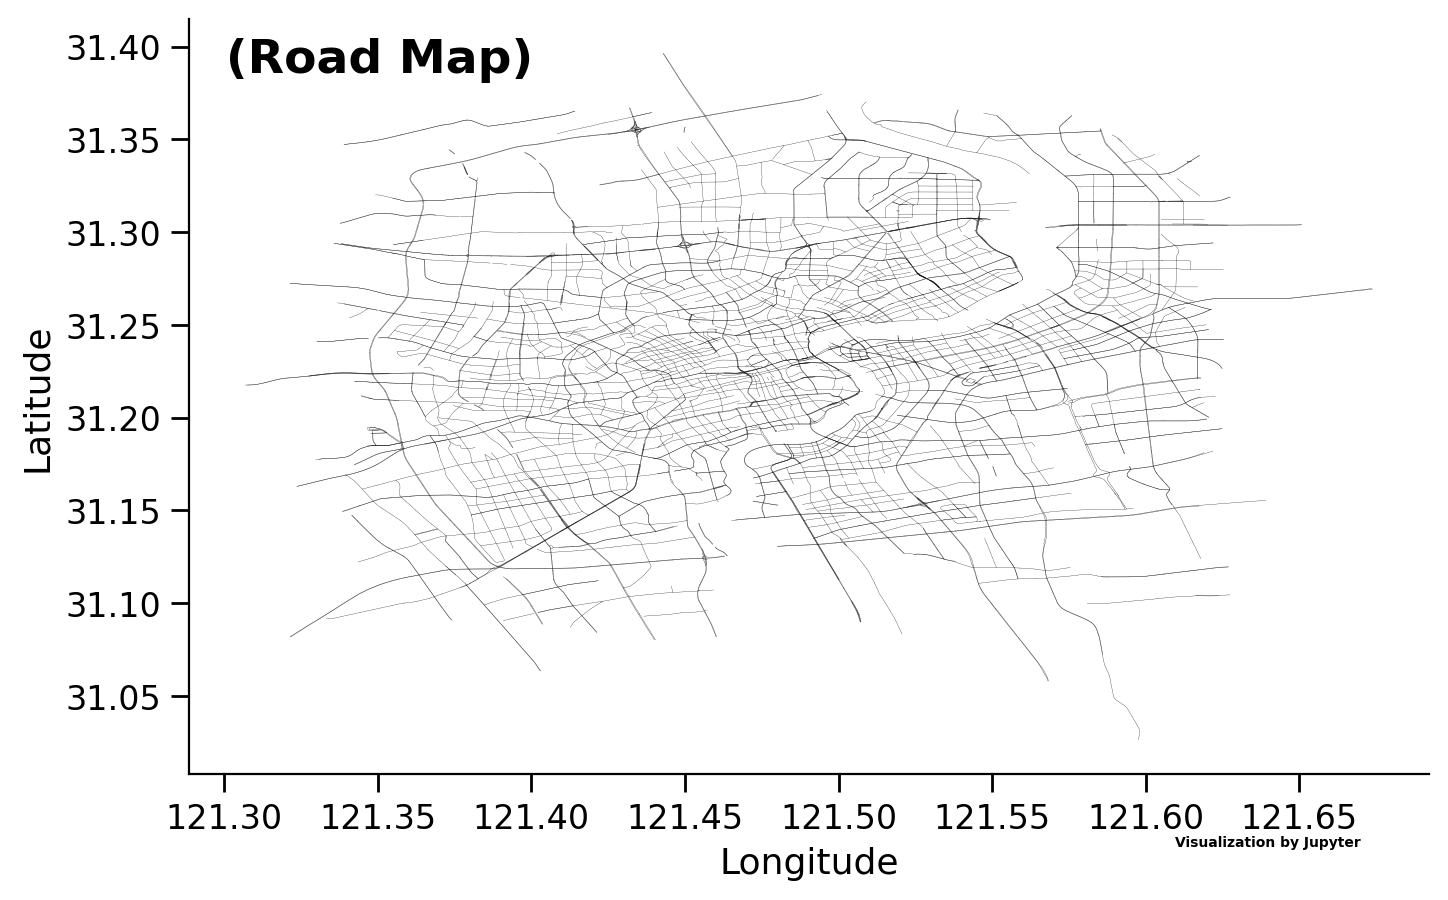

In [26]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
# 绘制上海行政区边界
# for line in sh_poly_lines:
#     ax.plot(line[0],line[1],color='black',linewidth=.1)
# 绘制各条道路的线条
for way in way_list:
    road_polyline=np.array([node_dict_amap[ref] for ref in way[1]],dtype='float')
    #road_polyline=np.array([road_polyline[0],road_polyline[-1]])
    road_polyline=road_polyline.T
    ax.plot(road_polyline[0],road_polyline[1],color='black',linewidth=.1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Road Map)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 构建拓扑图

In [5]:
graph={}
for way in way_list:
    name=way[0]
    for i in range(1,len(way[1])):
        s,d=way[1][i-1],way[1][i]#某条边的起讫点
        if s not in graph:
            graph[s]=[[],[[name,d]]]
        else:
            graph[s][1].append([name,d])
        if d not in graph:
            graph[d]=[[[name,s]],[]]
        else:
            graph[d][0].append([name,s])
# 去除非交点的中间节点
del_vertex=[]
for v,e in graph.items():
#     if len(e[0])==0 and len(e[1])==1:
#         del_vertex.append(v)
#         descendant=e[1][0][1]
#         graph[descendant][0].remove([e[1][0][0],v])
#     elif len(e[0])==1 and len(e[1])==0:
#         del_vertex.append(v)
#         ancestor=e[0][0][1]
#         graph[ancestor][1].remove([e[0][0][0],v])
    if len(e[0])==1 and len(e[1])==1 and e[0][0][0]==e[1][0][0]:# 筛选无用节点
        del_vertex.append(v)
        ancestor=e[0][0][1]
        descendant=e[1][0][1]
        for i in range(len(graph[ancestor][1])):
            if graph[ancestor][1][i][1]==v:
                graph[ancestor][1][i][1]=descendant
                break
        for i in range(len(graph[descendant][0])):
            if graph[descendant][0][i][1]==v:
                graph[descendant][0][i][1]=ancestor
                break 
print(f"删除了{len(del_vertex)}个节点")
for v in del_vertex:
    if v in graph:
        graph.pop(v)
print(f"剩余{len(graph)}个节点")

删除了38361个节点
剩余4566个节点


绘制拓扑图

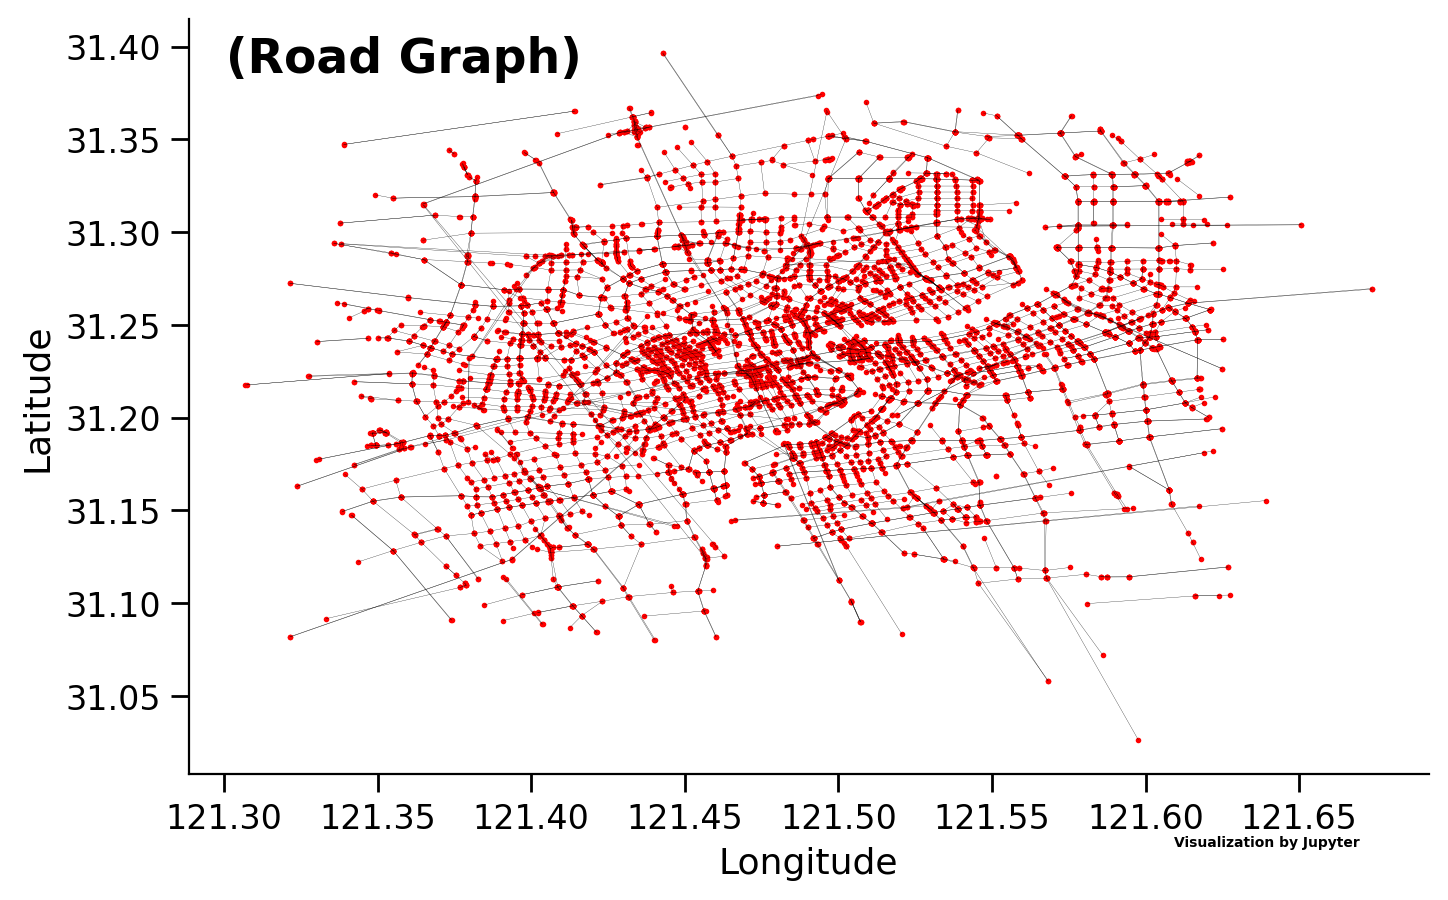

In [6]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for v,e in graph.items():
    for oute in e[1]:
        ax.plot([float(ref[v][0]),float(ref[oute[1]][0])],[float(ref[v][1]),float(ref[oute[1]][1])],color='black',linewidth=.1)
        ax.scatter([float(ref[v][0]),float(ref[oute[1]][0])],[float(ref[v][1]),float(ref[oute[1]][1])],color='r',s=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Road Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 保存图数据

In [7]:
import pickle
with open('../data/graph.pkl','wb') as f:
    pickle.dump(graph, f)